### 0. Import libraries and load data

In [1]:
import os
import sys
import json
import h5py
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Input, Conv2D, Conv2DTranspose


sns.set()

FOLDER_PATH = "../data/"
DATABASE_FILE_NAME = "database/database_lite.json"
QUERY_FILE_NAME = "query/query_lite.json"
SIMILARITY_FILE_NAME = "london_lite_gt.h5"


In [2]:
# map
with open(FOLDER_PATH + DATABASE_FILE_NAME, "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc = np.array(m_idx["loc"])

# query
with open(FOLDER_PATH + QUERY_FILE_NAME, "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    q_loc = np.array(q_idx["loc"])
    
# loading the relevance judgements
with h5py.File(FOLDER_PATH + SIMILARITY_FILE_NAME, "r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)


### 1. Pre-process images

In [3]:
def get_image_shapes(image_paths):
    image_shapes = set()

    for image_path in image_paths:
        img = plt.imread(os.path.join(FOLDER_PATH + image_path))
        image_shapes.add(img.shape)
        
    return image_shapes


In [4]:
def get_smallest_image_size(m_imgs_shapes, q_imgs_shapes):
    smallest_shape = None
    smallest_size = sys.maxsize
    imgs_shapes = q_imgs_shapes.union(m_imgs_shapes)

    for img_shape in imgs_shapes:
        image_size = img_shape[0] * img_shape[1] * img_shape[2]

        if image_size <= smallest_size:
            smallest_size = image_size
            smallest_shape = img_shape
            
    new_even_dims = []

    for dim_index in range(len(smallest_shape) - 1):
        if smallest_shape[dim_index] % 2 == 1:
            new_even_dims.append(smallest_shape[dim_index] - 1)
        else:
            new_even_dims.append(smallest_shape[dim_index])

    smallest_shape_even = (new_even_dims[0], new_even_dims[1], smallest_shape[2])
    print(f"\nSmallest image shape with even sizes is: {smallest_shape_even}")

    return smallest_shape_even


In [5]:
m_imgs_shapes = get_image_shapes(m_imgs)
print(f"Shapes of database images:\n{m_imgs_shapes}")

q_imgs_shapes = get_image_shapes(q_imgs)
print(f"\nShapes of query images:\n{q_imgs_shapes}")

smallest_image_shape = get_smallest_image_size(m_imgs_shapes, q_imgs_shapes)


Shapes of database images:
{(256, 455, 3), (256, 341, 3), (256, 367, 3)}

Shapes of query images:
{(256, 341, 3), (256, 455, 3)}

Smallest image shape with even sizes is: (256, 340, 3)


In [6]:
def load_images(image_paths, image_size):
    preprocessed_images = np.zeros(
        (len(image_paths), image_size[0], image_size[1], image_size[2])
    )

    for index, image_path in enumerate(image_paths):
        raw_img = image.load_img(FOLDER_PATH + image_path)
        resized_img = tf.image.resize(raw_img, (image_size[0], image_size[1]))
        scaled_img = resized_img / 255
        array_img = image.img_to_array(scaled_img).astype("float32")
        preprocessed_images[index] = array_img
        
    return preprocessed_images


In [7]:
database_images = load_images(m_imgs, smallest_image_shape)
print(f"Shape of database dataset: {database_images.shape}")

query_images = load_images(q_imgs, smallest_image_shape)
print(f"Shape of query dataset: {query_images.shape}")


Shape of database dataset: (1000, 256, 340, 3)
Shape of query dataset: (500, 256, 340, 3)


In [8]:
def display_reshaped_image(database_images, m_imgs, image_index):
    _, ax = plt.subplots(2, 1)
    ax[0].imshow(plt.imread(os.path.join(FOLDER_PATH + m_imgs[image_index])))
    ax[0].set_title("Original image")

    ax[1].imshow(database_images[image_index])
    ax[1].set_title("Resized image")

    plt.show()


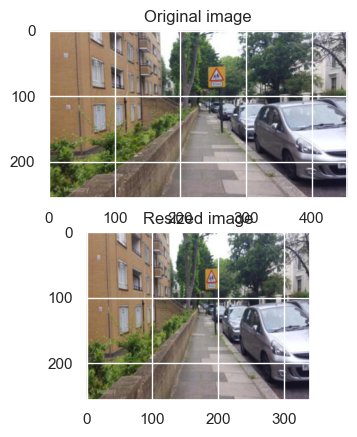

In [9]:
display_reshaped_image(database_images, m_imgs, image_index=6)


### 2. Build Autoencoder

In [10]:
input_layer = Input(shape=smallest_image_shape)   
conv_2d_1 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
conv_2d_2 = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(conv_2d_1)

conv_2d_t_1 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv_2d_2)
conv_2d_t_2 = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv_2d_t_1)
output_layer = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv_2d_t_2)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=conv_2d_2)

autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 340, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 170, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 85, 8)         1160      
                                                                 
 conv2d_transpose (Conv2DTr  (None, 128, 170, 8)       584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 256, 340, 16)      1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 340, 3)       435   

In [11]:
history = autoencoder.fit(database_images, database_images, epochs=3, batch_size=64, validation_split=0.1, shuffle=True)

Epoch 1/3
15/15 [==============================] - 56s 4s/step - loss: 0.0629 - val_loss: 0.0751
Epoch 2/3
15/15 [==============================] - 58s 4s/step - loss: 0.0570 - val_loss: 0.0608
Epoch 3/3
15/15 [==============================] - 56s 4s/step - loss: 0.0454 - val_loss: 0.0414


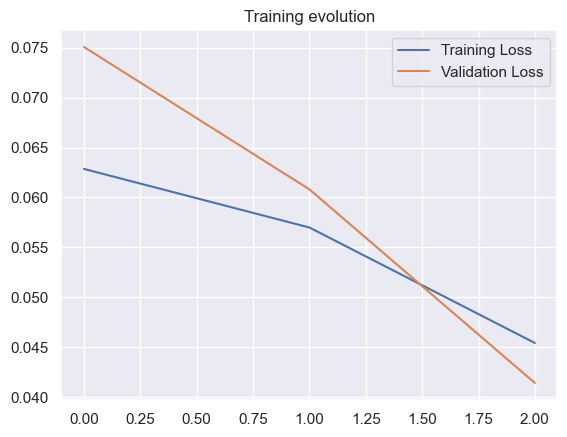

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title("Training evolution")
plt.legend(["Training Loss", "Validation Loss"])

In [13]:
# TODO: define a cross-validation function
# TODO: find the hyperparameters space
# TODO: optimize the model
# TODO: predict the latent space for each image
# TODO: store the model and latent spaces